In [147]:
# Import statements
%pip install pykrige
%pip install xgboost
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
from pykrige.ok import OrdinaryKriging
from sklearn.preprocessing import MinMaxScaler


Note: you may need to restart the kernel to use updated packages.


In [148]:
# Load dataset
df = pd.read_csv('sweetspot_UT_Austin.csv')

# Well number and name are redundant (can use row index) and can be removed.
df.drop(columns=['Well Number', 'Well Name'], inplace=True)

# Rename column headers to be more human-readable
mappings = {
    'Bottomhole X': 'bh_x',         # Bottomhole X-coordinate
    'Bottomhole Y': 'bh_y',         # Bottomhole Y-coordinate
    'Co [MSTB]': 'oil_prod_mstb',   # Cumulative oil production, thousand stock tank barrels
    'Cw (bbl)': 'water_prod_bbl',   # Cumulative water production, barrels
    'POROS': 'porosity',            # Porosity
    'KX': 'perm_x',                 # X permeability
    'KY': 'perm_y',                 # Y permeability
    'TD(MD)': 'total_depth_md',     # Total depth (measured depth)
    'Cg (mmcf)': 'gas_prod_mmcf',   # Gas production, million cubic feet
    'FACIES': 'facies',             # Facies
    'P_2020-1-6': 'past_pressure',  # Pressure on January 6, 2020
    'P_2029-1-1': 'future_pressure' # Predicted pressure on January 1, 2029
}
df.rename(columns=mappings, inplace=True)

# Add harmonic mean permeability to dataframe
df['perm_hm'] = 2 * df['perm_x'] * df['perm_y'] / (df['perm_x'] + df['perm_y'])

# One-hot encode facies since it is categorical
df = pd.get_dummies(df, columns=['facies'], drop_first=True)

# Convert facies dummy variables to single categorical column BEFORE scaling
def get_facies_label(row):
    if row.get('facies_2', 0) == 1:
        return 2
    elif row.get('facies_3', 0) == 1:
        return 3
    elif row.get('facies_4', 0) == 1:
        return 4
    elif row.get('facies_5', 0) == 1:
        return 5
    else:
        return 1  # Default facies_1 if all others are 0

# Create facies column in original df before scaling
df['facies'] = df.apply(get_facies_label, axis=1)

# Scale relevant columns
columns_to_scale = ['perm_hm', 'porosity', 'oil_prod_mstb', 'gas_prod_mmcf', 
                    'total_depth_md', 'water_prod_bbl']

# Replace inf values and drop rows with NaN in columns to scale
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)

# Create scaled dataframe
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Keep facies column in df_scaled (already created above)
df_scaled['facies'] = df['facies']

print(f"Dataset shape: {df.shape}")
print(f"Scaled dataset shape: {df_scaled.shape}")
print(f"Facies distribution:\n{df['facies'].value_counts().sort_index()}")


def create_kriging_plot(df, x_col, y_col, z_col=None, title='', cmap='YlOrRd',
                        add_contours=False, contour_col=None, z_grid=None,
                        grid_x=None, grid_y=None):
    import matplotlib.pyplot as plt
    
    if z_grid is None:
        # Existing kriging code to compute z_grid
        x = df[x_col].values
        y = df[y_col].values
        z = df[z_col].values
        mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
        x, y, z = x[mask], y[mask], z[mask]

        grid_x = np.linspace(x.min(), x.max(), 100)
        grid_y = np.linspace(y.min(), y.max(), 100)

        OK = OrdinaryKriging(x, y, z, variogram_model='spherical',
                             verbose=False, enable_plotting=False)
        z_grid, ss = OK.execute('grid', grid_x, grid_y)

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(z_grid.T, extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()],
                   origin='lower', cmap=cmap, aspect='auto')
    plt.colorbar(im, ax=ax, label=title)

    # Plot wells in black
    ax.scatter(df['bh_x'], df['bh_y'], c='black', s=80, edgecolor='white', linewidth=1.5, alpha=0.8)
    if add_contours and contour_col is not None:
    
        # Extract contour data
        contour_x = df_scaled[x_col].values
        contour_y = df_scaled[y_col].values
        contour_z = df_scaled[contour_col].values
        
        # Remove NaNs
        mask = ~(np.isnan(contour_x) | np.isnan(contour_y) | np.isnan(contour_z))
        contour_x, contour_y, contour_z = contour_x[mask], contour_y[mask], contour_z[mask]
        
        # Kriging for contour data
        OK_contour = OrdinaryKriging(contour_x, contour_y, contour_z,
                                    variogram_model='spherical',
                                    verbose=False, enable_plotting=False)
        contour_pred, _ = OK_contour.execute('grid', grid_x, grid_y)
        
        # Plot contours over facies probability
        contours = ax.contour(grid_x, grid_y, contour_pred.T,
                            colors='black', linewidths=1.5, levels=8, alpha=0.7)
        ax.clabel(contours, inline=True, fontsize=8, fmt='%0.1f')
    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    return fig, ax


Dataset shape: (55, 17)
Scaled dataset shape: (55, 17)
Facies distribution:
facies
1    11
2    11
3    11
4    11
5    11
Name: count, dtype: int64


In [149]:
# Size and top 8 rows in dataset
print('Data size:', df_scaled.shape)
df_scaled.head(n=8)

Data size: (55, 17)


,bh_x,bh_y,oil_prod_mstb,water_prod_bbl,porosity,perm_x,perm_y,total_depth_md,gas_prod_mmcf,past_pressure,future_pressure,perm_hm,facies_2,facies_3,facies_4,facies_5,facies
0,5064.04,13746.23,0.457100,1.745744e-06,0.511559,0.020377,0.020377,0.353722,0.317559,3491.971374,2992.403113,0.349677,False,True,False,False,3
1,7668.40,13746.23,0.228000,1.505296e-06,0.305572,0.015088,0.015088,0.435084,0.141138,3501.327981,2947.374808,0.258610,False,False,True,False,4
2,2459.67,13746.23,0.400470,2.130768e-06,0.442178,0.022396,0.022396,0.369302,0.272412,3493.763065,2904.053641,0.384431,False,False,True,False,4
3,10272.76,13746.23,0.004738,6.306559e-10,0.008303,0.000091,0.000091,0.595499,0.002226,3519.775759,3301.826052,0.000422,False,False,False,True,5
4,12877.11,13746.23,0.003565,0.000000e+00,0.000000,0.000067,0.000067,0.835257,0.000879,3547.347889,3365.597401,0.000000,False,False,False,True,5
5,10272.76,11141.88,0.008244,3.222393e-09,0.062447,0.000168,0.000168,0.364686,0.005643,3493.232193,3196.746890,0.001740,False,False,False,True,5
6,11430.25,11141.88,0.001781,6.511770e-03,0.049650,0.000162,0.000162,0.461627,0.001058,3504.380491,3126.405930,0.001640,False,False,False,True,5
7,12877.11,11141.88,0.000000,1.344031e-02,0.087970,0.000270,0.000270,0.604443,0.000000,3520.804323,2949.434450,0.003495,False,False,False,True,5


In [150]:
# Missing value imputation

# Replace 0s with NaN 
df_scaled['oil_prod_mstb'] = df_scaled['oil_prod_mstb'].replace(0, np.nan)
df_scaled['gas_prod_mmcf'] = df_scaled['gas_prod_mmcf'].replace(0, np.nan)

# Median imputation (safer than mean due to outliers)
df_scaled['oil_prod_mstb'] = df_scaled['oil_prod_mstb'].fillna(df['oil_prod_mstb'].median())
df_scaled['gas_prod_mmcf'] = df_scaled['gas_prod_mmcf'].fillna(df['gas_prod_mmcf'].median())

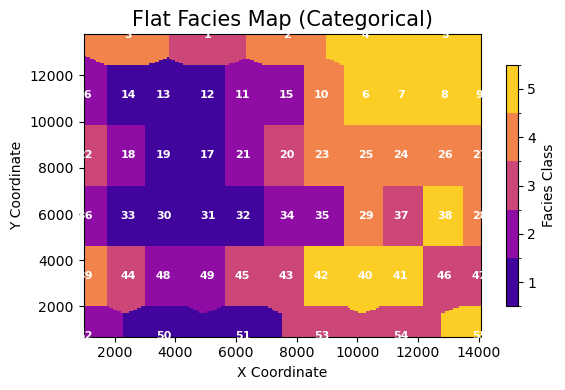

In [151]:
x = df['bh_x']
y = df['bh_y']
c = df_scaled['facies']

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use NEAREST interpolation for categorical data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='nearest')

# Define discrete colormap (you can customize colors)
facies_values = np.sort(df_scaled['facies'].unique())
n_facies = len(facies_values)
colors = plt.cm.plasma(np.linspace(0.1, 0.9, n_facies))
cmap = ListedColormap(colors)

# Set up discrete normalization boundaries
bounds = np.arange(facies_values.min() - 0.5, facies_values.max() + 1.5, 1)
norm = BoundaryNorm(bounds, cmap.N)

# Plot
plt.figure(figsize=(6, 4))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, s=40)

for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(
        xi, yi, str(df.index[i] + 1),  # label = row index
        color='white', fontsize=8, fontweight='bold',
        ha='center', va='center', zorder=4
    )

plt.title('Flat Facies Map (Categorical)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Discrete colorbar with labels for each facies
cbar = plt.colorbar(pcm, shrink=0.8, ticks=facies_values)
cbar.set_label('Facies Class')
plt.tight_layout()
plt.show()


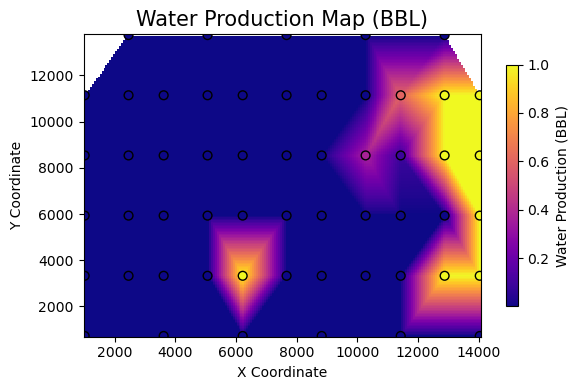

In [152]:
x = df['bh_x']
y = df['bh_y']
c = df['water_prod_bbl']  # continuous variable
c = np.clip(c, 0, 1)

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use LINEAR interpolation for continuous data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='linear')

# Normalize colors for continuous mapping
norm = Normalize(vmin=np.nanmin(c), vmax=np.nanmax(c))
cmap = plt.cm.plasma  # choose any colormap: 'viridis', 'inferno', 'coolwarm', etc.

# Plot
plt.figure(figsize=(6, 4))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, edgecolor='k', s=40)

plt.title('Water Production Map (BBL)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Continuous colorbar
cbar = plt.colorbar(pcm, shrink=0.8)
cbar.set_label('Water Production (BBL)')
plt.tight_layout()
plt.show()


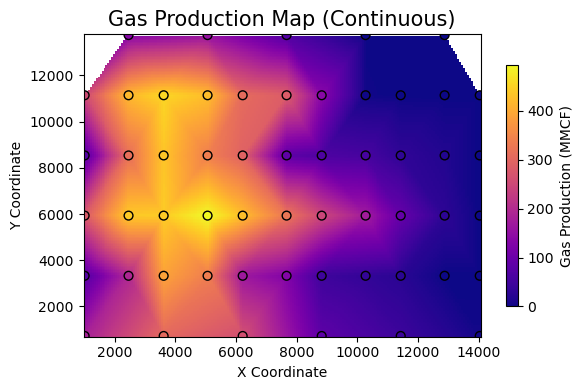

In [153]:
x = df['bh_x']
y = df['bh_y']
c = df['gas_prod_mmcf']  # continuous variable

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use LINEAR interpolation for continuous data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='linear')

# Normalize colors for continuous mapping
norm = Normalize(vmin=np.nanmin(c), vmax=np.nanmax(c))
cmap = plt.cm.plasma  # choose any colormap: 'viridis', 'inferno', 'coolwarm', etc.

# Plot
plt.figure(figsize=(6, 4))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, edgecolor='k', s=40)

plt.title('Gas Production Map (Continuous)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Continuous colorbar
cbar = plt.colorbar(pcm, shrink=0.8)
cbar.set_label('Gas Production (MMCF)')
plt.tight_layout()
plt.show()


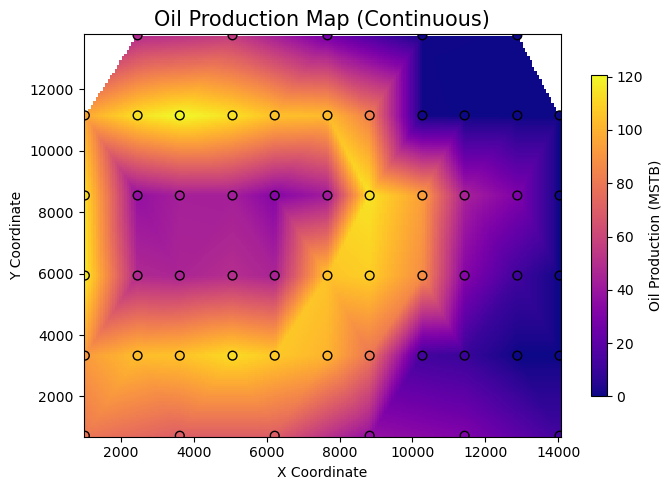

In [154]:
x = df['bh_x']
y = df['bh_y']
c = df['oil_prod_mstb']  # continuous variable

# Create interpolation grid
grid_x, grid_y = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]

# Use LINEAR interpolation for continuous data
grid_c = griddata((x, y), c, (grid_x, grid_y), method='linear')

# Normalize colors for continuous mapping
norm = Normalize(vmin=np.nanmin(c), vmax=np.nanmax(c))
cmap = plt.cm.plasma  # choose any colormap: 'viridis', 'inferno', 'coolwarm', etc.

# Plot
plt.figure(figsize=(7, 5))
pcm = plt.pcolormesh(grid_x, grid_y, grid_c, cmap=cmap, norm=norm, shading='auto')
plt.scatter(x, y, c=c, cmap=cmap, norm=norm, edgecolor='k', s=40)

plt.title('Oil Production Map (Continuous)', fontsize=15)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Continuous colorbar
cbar = plt.colorbar(pcm, shrink=0.8)
cbar.set_label('Oil Production (MSTB)')
plt.tight_layout()
plt.show()


C:\Users\shake\AppData\Local\Temp\ipykernel_18032\700364222.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])


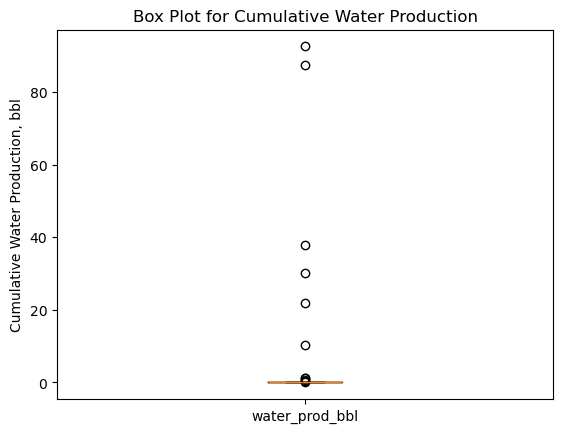

In [155]:
# Water production box plot
plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])
plt.title('Box Plot for Cumulative Water Production')
plt.ylabel('Cumulative Water Production, bbl')
plt.show()

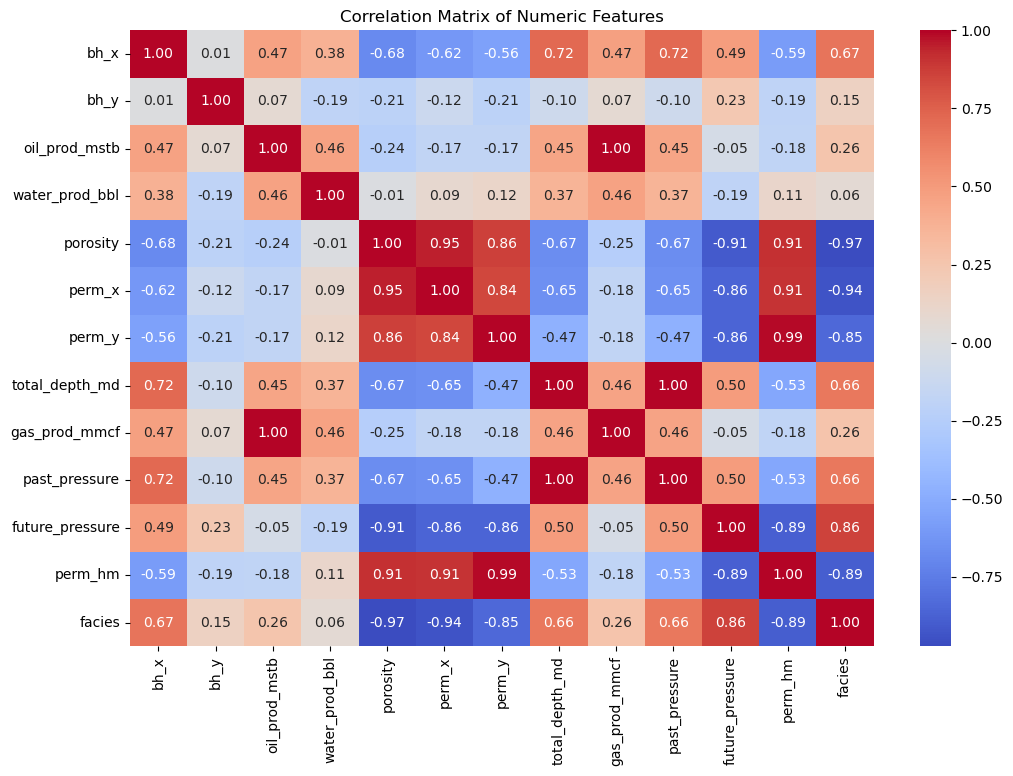

In [156]:
# Heatmap to display correlations
numeric_df = df_scaled.select_dtypes(include=[np.number])

# Compute correlation matrix on numeric columns
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [157]:
perm = 2 * df['perm_x'].astype(float) * df['perm_y'].astype(float) / (df['perm_x'].astype(float) + df['perm_y'].astype(float))
print(perm)

0     0.020377
1     0.015088
2     0.022396
3     0.000091
4     0.000067
5     0.000168
6     0.000162
7     0.000270
8     0.000284
9     0.015151
10    0.038947
11    0.050873
12    0.056463
13    0.052861
14    0.037831
15    0.034999
16    0.027062
17    0.019848
18    0.024499
19    0.013012
20    0.021804
21    0.012884
22    0.012158
23    0.004877
24    0.008402
25    0.009065
26    0.015409
27    0.012573
28    0.022922
29    0.053718
30    0.058151
31    0.047167
32    0.050863
33    0.036493
34    0.030338
35    0.038392
36    0.013927
37    0.004137
38    0.009499
39    0.003991
40    0.002784
41    0.004627
42    0.017898
43    0.026014
44    0.038956
45    0.038350
46    0.038000
47    0.041674
48    0.042639
49    0.055685
50    0.044984
51    0.034241
52    0.016377
53    0.012992
54    0.004627
dtype: float64


In [158]:
# Add harmonic mean permeability to dataframe
df['perm_hm'] = perm
df.head()

,bh_x,bh_y,oil_prod_mstb,water_prod_bbl,porosity,perm_x,perm_y,total_depth_md,gas_prod_mmcf,past_pressure,future_pressure,perm_hm,facies_2,facies_3,facies_4,facies_5,facies
0,5064.04,13746.23,55.191600,1.617450e-04,0.128029,0.020377,0.020377,8551.7,157.119447,3491.971374,2992.403113,0.020377,False,True,False,False,3
1,7668.40,13746.23,27.529400,1.394790e-04,0.101876,0.015088,0.015088,8579.9,69.831076,3501.327981,2947.374808,0.015088,False,False,True,False,4
2,2459.67,13746.23,48.354000,1.973990e-04,0.119220,0.022396,0.022396,8557.1,134.781940,3493.763065,2904.053641,0.022396,False,False,True,False,4
3,10272.76,13746.23,0.572057,1.440000e-07,0.064132,0.000091,0.000091,8635.5,1.101210,3519.775759,3301.826052,0.000091,False,False,False,True,5
4,12877.11,13746.23,0.430394,8.560000e-08,0.063078,0.000067,0.000067,8718.6,0.435085,3547.347889,3365.597401,0.000067,False,False,False,True,5


In [159]:
columns_to_scale = ['perm_hm', 'porosity', 'oil_prod_mstb', 'gas_prod_mmcf', 'total_depth_md', 'water_prod_bbl']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_scale)
# Scale the relevant columns between 0 and 1
scale = MinMaxScaler()
df_scaled = df.copy()
df_scaled[columns_to_scale] = scale.fit_transform(df[columns_to_scale])

In [160]:
df_scaled.head()

,bh_x,bh_y,oil_prod_mstb,water_prod_bbl,porosity,perm_x,perm_y,total_depth_md,gas_prod_mmcf,past_pressure,future_pressure,perm_hm,facies_2,facies_3,facies_4,facies_5,facies
0,5064.04,13746.23,0.457100,1.745744e-06,0.511559,0.020377,0.020377,0.353722,0.317559,3491.971374,2992.403113,0.349677,False,True,False,False,3
1,7668.40,13746.23,0.228000,1.505296e-06,0.305572,0.015088,0.015088,0.435084,0.141138,3501.327981,2947.374808,0.258610,False,False,True,False,4
2,2459.67,13746.23,0.400470,2.130768e-06,0.442178,0.022396,0.022396,0.369302,0.272412,3493.763065,2904.053641,0.384431,False,False,True,False,4
3,10272.76,13746.23,0.004738,6.306559e-10,0.008303,0.000091,0.000091,0.595499,0.002226,3519.775759,3301.826052,0.000422,False,False,False,True,5
4,12877.11,13746.23,0.003565,0.000000e+00,0.000000,0.000067,0.000067,0.835257,0.000879,3547.347889,3365.597401,0.000000,False,False,False,True,5


C:\Users\shake\AppData\Local\Temp\ipykernel_18032\2314285338.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


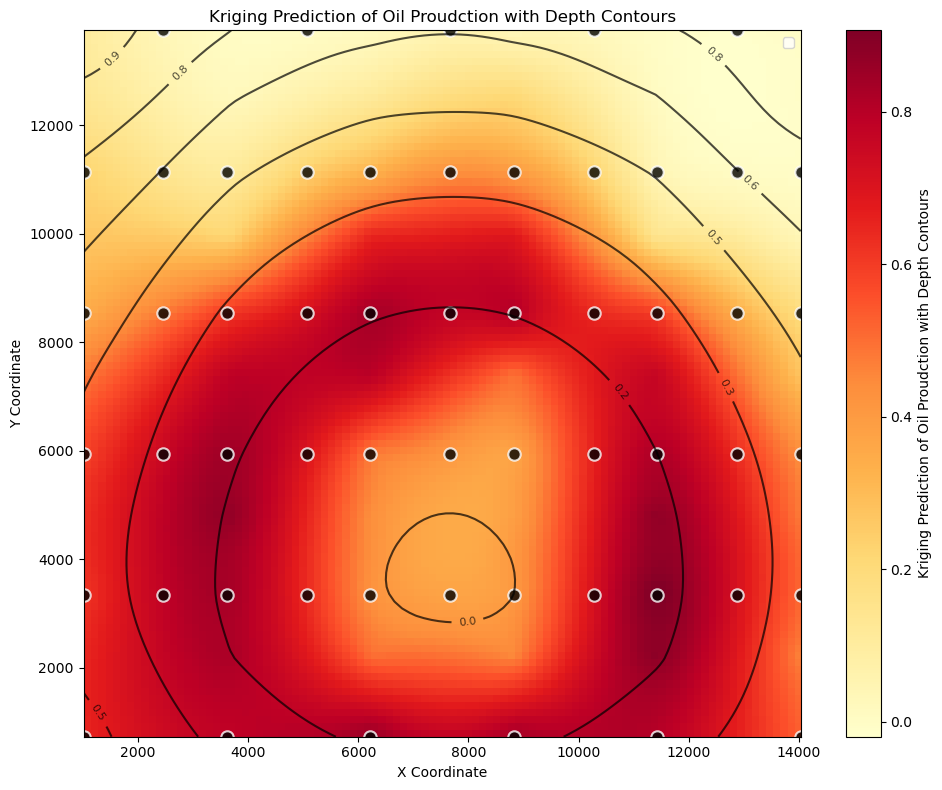

In [161]:
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'oil_prod_mstb', 'Kriging Prediction of Oil Proudction with Depth Contours', cmap='YlOrRd', 
                        add_contours=True, contour_col='total_depth_md')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_18032\2314285338.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


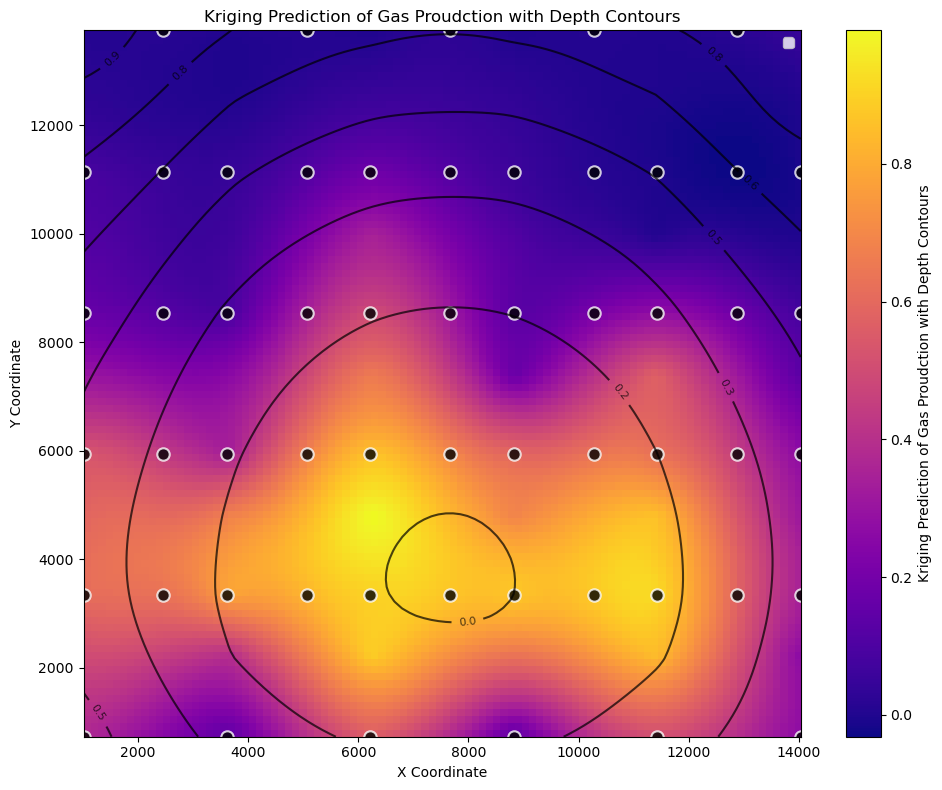

In [162]:
# Kriging interpolation and contour plotting (Gas Production)
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'gas_prod_mmcf', 'Kriging Prediction of Gas Proudction with Depth Contours', cmap='plasma', 
                        add_contours=True, contour_col='total_depth_md')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_18032\2314285338.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


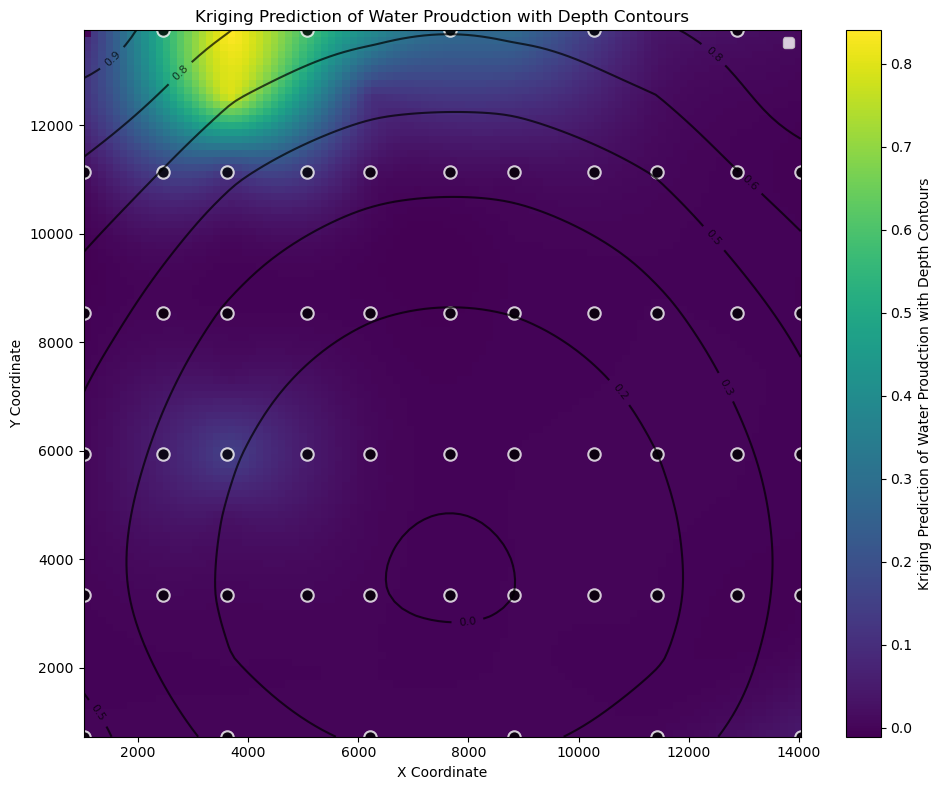

In [163]:
# Kriging interpolation and contour plotting (Water Production)
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'water_prod_bbl', 'Kriging Prediction of Water Proudction with Depth Contours', cmap='viridis', 
                        add_contours=True, contour_col='total_depth_md')
plt.show()

In [164]:
# Define top-performing wells (top quartile)
top_oil_threshold = df_scaled['oil_prod_mstb'].quantile(0.75)
top_gas_threshold = df_scaled['gas_prod_mmcf'].quantile(0.75)

df_scaled['top_oil_well'] = df_scaled['oil_prod_mstb'] >= top_oil_threshold
df_scaled['top_gas_well'] = df_scaled['gas_prod_mmcf'] >= top_gas_threshold

# Check if facies dummy columns exist
facies_cols = ['facies_2', 'facies_3', 'facies_4', 'facies_5']

if all(col in df_scaled.columns for col in facies_cols):
    # If dummy columns exist, use them
    print('Facies sums in top oil wells:')
    print(df_scaled.loc[df_scaled['top_oil_well'], facies_cols].sum())
    print('\nFacies sums in top gas wells:')
    print(df_scaled.loc[df_scaled['top_gas_well'], facies_cols].sum())
else:
    # If dummy columns don't exist, use the 'facies' column instead
    print('Facies distribution in top oil wells:')
    print(df_scaled.loc[df_scaled['top_oil_well'], 'facies'].value_counts().sort_index())
    print('\nFacies distribution in top gas wells:')
    print(df_scaled.loc[df_scaled['top_gas_well'], 'facies'].value_counts().sort_index())
    
    # Also show as percentages
    print('\nFacies percentages in top oil wells:')
    print(df_scaled.loc[df_scaled['top_oil_well'], 'facies'].value_counts(normalize=True).sort_index() * 100)
    print('\nFacies percentages in top gas wells:')
    print(df_scaled.loc[df_scaled['top_gas_well'], 'facies'].value_counts(normalize=True).sort_index() * 100)

Facies sums in top oil wells:
facies_2    7
facies_3    3
facies_4    1
facies_5    0
dtype: int64

Facies sums in top gas wells:
facies_2    5
facies_3    0
facies_4    0
facies_5    0
dtype: int64


In [165]:
# Porosity & permeability stats in top wells
print('\nPorosity in top oil wells:')
print(df[df_scaled['top_oil_well']]['porosity'].describe())
print('\nPermeability in top oil wells:')
print(df[df_scaled['top_oil_well']]['perm_hm'].describe())


Porosity in top oil wells:
count    14.000000
mean      0.164826
std       0.020093
min       0.117819
25%       0.158312
50%       0.169857
75%       0.176481
max       0.188017
Name: porosity, dtype: float64

Permeability in top oil wells:
count    14.000000
mean      0.036894
std       0.013158
min       0.012158
25%       0.031877
50%       0.038669
75%       0.042398
max       0.056463
Name: perm_hm, dtype: float64


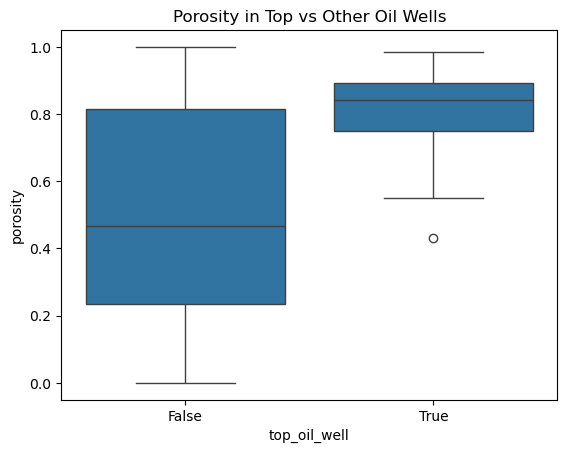

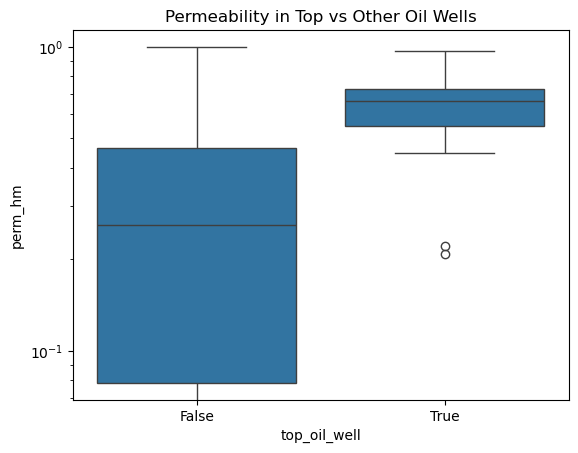

In [166]:
# Visualize distributions
sns.boxplot(data=df_scaled, x='top_oil_well', y='porosity')
plt.title('Porosity in Top vs Other Oil Wells')
plt.show()

sns.boxplot(data=df_scaled, x='top_oil_well', y='perm_hm')
plt.yscale('log')
plt.title('Permeability in Top vs Other Oil Wells')
plt.show()

array([[<Axes: title={'center': 'oil_prod_mstb'}>,
        <Axes: title={'center': 'gas_prod_mmcf'}>]], dtype=object)

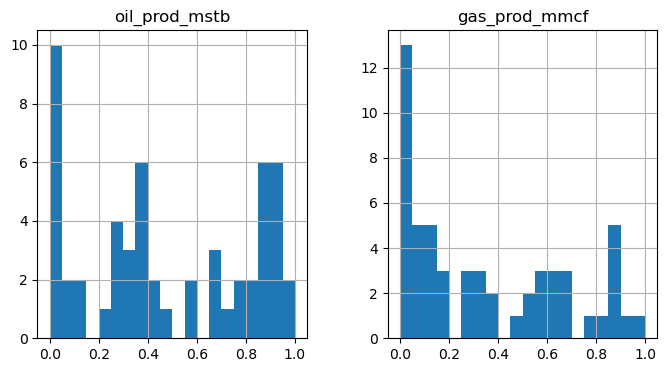

In [167]:
# Histograms
df_scaled[['oil_prod_mstb','gas_prod_mmcf']].hist(bins=20, figsize=(8,4))

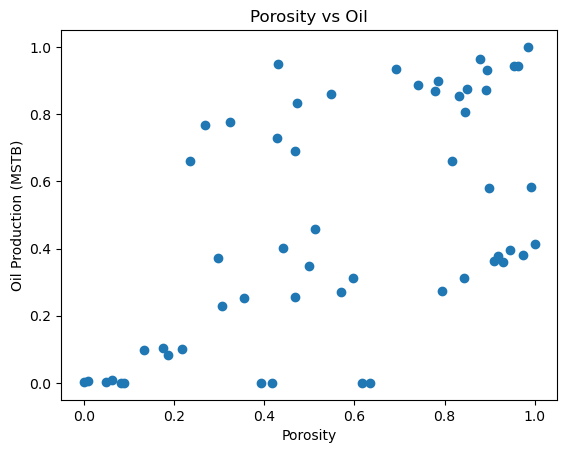

In [168]:
# Scatter plot of porosity vs oil production
plt.scatter(df_scaled['porosity'], df_scaled['oil_prod_mstb'])
plt.xlabel('Porosity'); plt.ylabel('Oil Production (MSTB)'); plt.title('Porosity vs Oil')
plt.show()

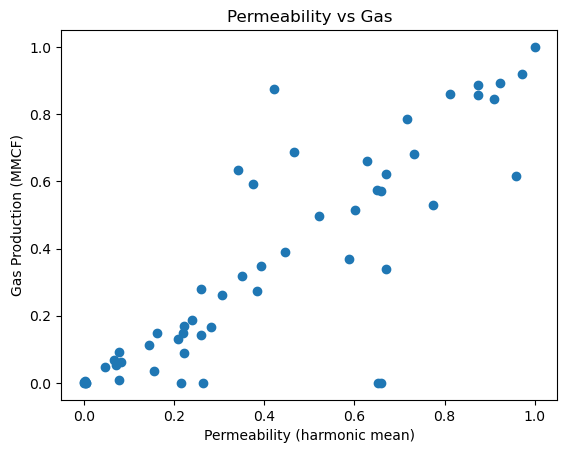

In [169]:
# Scatter plot of permeability vs gas production
plt.scatter(df_scaled['perm_hm'], df_scaled['gas_prod_mmcf'])
plt.xlabel('Permeability (harmonic mean)'); plt.ylabel('Gas Production (MMCF)'); plt.title('Permeability vs Gas')
plt.show()

In [170]:
# Facies among top producers
# One-hot encode facies since it is categorical
df = pd.get_dummies(df_scaled, columns=['facies'], drop_first=True)
top_oil = df.nlargest(10, 'oil_prod_mstb')
print(top_oil[['facies_2','facies_3','facies_4','facies_5']].sum())

facies_2    4
facies_2    4
facies_3    2
facies_3    2
facies_4    1
facies_4    1
facies_5    0
facies_5    0
dtype: int64


In [171]:
# Display top 5 wells by oil production
top_wells = df_scaled.nlargest(5, 'oil_prod_mstb')[['bh_x', 'bh_y', 'oil_prod_mstb', 'gas_prod_mmcf',
                                             'perm_hm', 'porosity', 'total_depth_md', 'past_pressure'] + facies_cols]
print(top_wells)

       bh_x      bh_y  oil_prod_mstb  gas_prod_mmcf   perm_hm  porosity  \
12  3617.17  11141.88       1.000000       0.919680  0.970942  0.984023   
35  1012.81   5933.16       0.963526       0.569751  0.659820  0.878828   
22  8825.89   8537.52       0.948946       0.129526  0.208175  0.431142   
11  5064.04  11141.88       0.943359       0.857965  0.874694  0.952730   
13  2459.67  11141.88       0.942920       0.843898  0.908931  0.961838   

    total_depth_md  past_pressure  facies_2  facies_3  facies_4  facies_5  
12        0.111945    3464.166989     False     False     False     False  
35        0.131852    3466.456371      True     False     False     False  
22        0.153780    3468.978010     False     False      True     False  
11        0.122908    3465.427808     False     False     False     False  
13        0.138488    3467.219499     False     False     False     False  


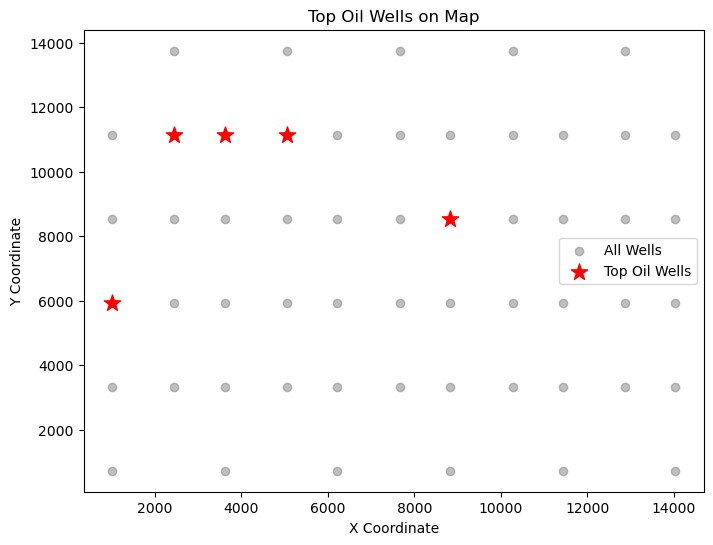

In [172]:
# Plot top oil wells on map
plt.figure(figsize=(8, 6))
plt.scatter(df['bh_x'], df['bh_y'], c='gray', alpha=0.5, label='All Wells')
plt.scatter(top_wells['bh_x'], top_wells['bh_y'], c='r', marker='*', s=150, label='Top Oil Wells')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Top Oil Wells on Map')
plt.legend()
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_18032\2314285338.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


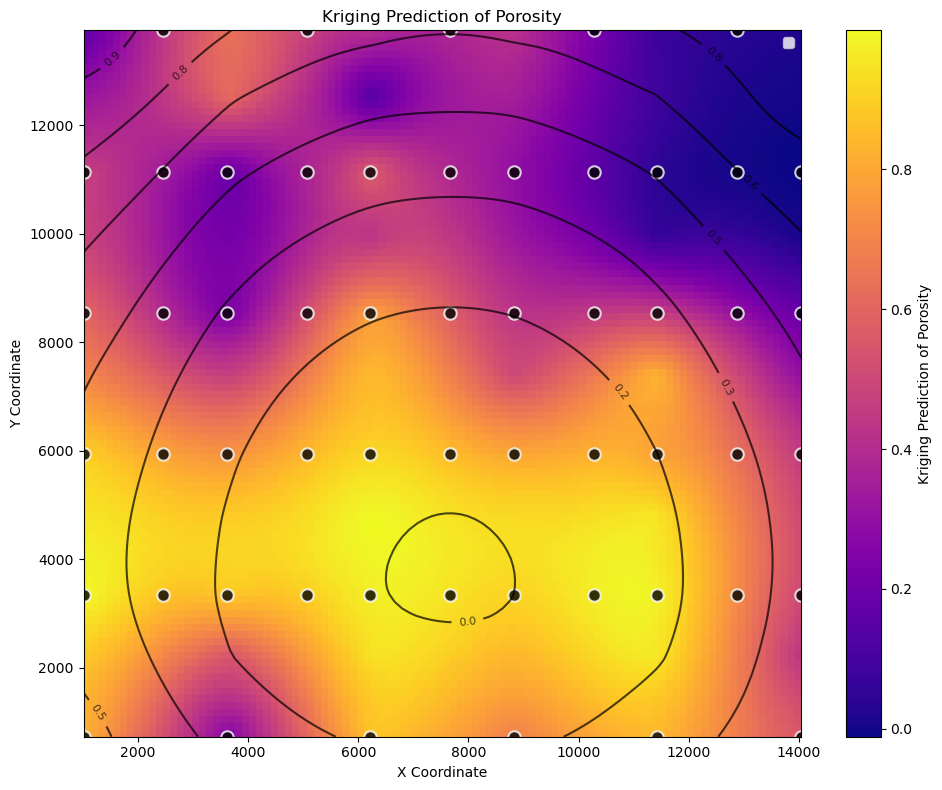

In [173]:
# Kriging plot for porosity
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'porosity', 
                    'Kriging Prediction of Porosity',
                    cmap='plasma', add_contours=True, contour_col='total_depth_md')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_18032\2314285338.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


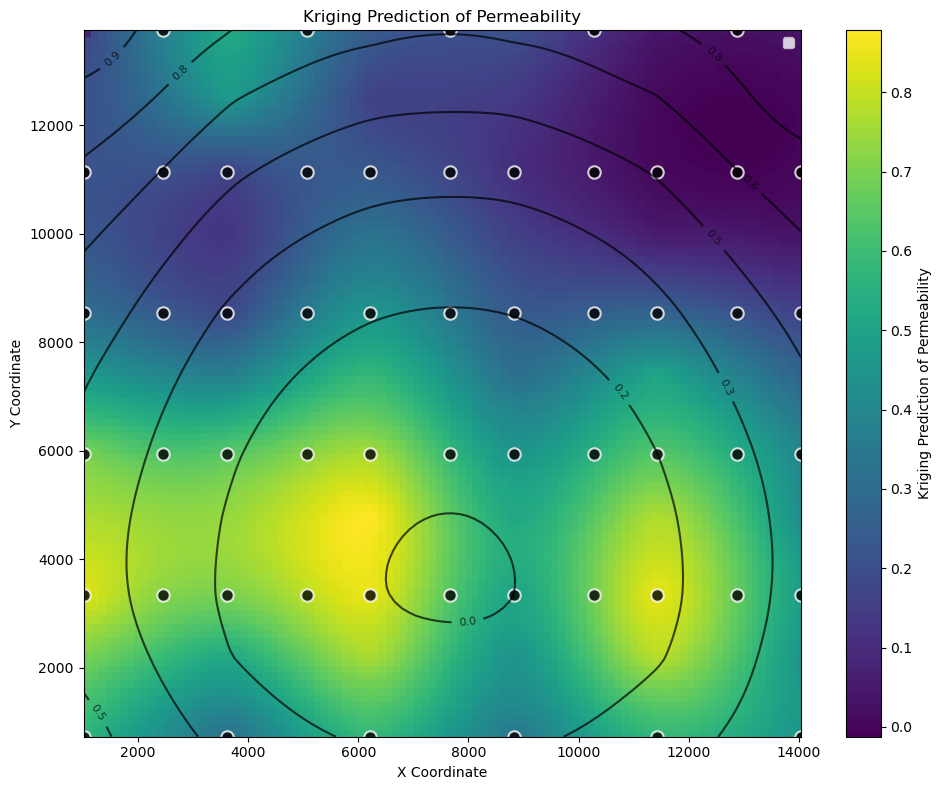

In [174]:
# Kriging plot for permeability
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'perm_hm', 
                    'Kriging Prediction of Permeability',
                    cmap='viridis', add_contours=True, contour_col='total_depth_md')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_18032\2314285338.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


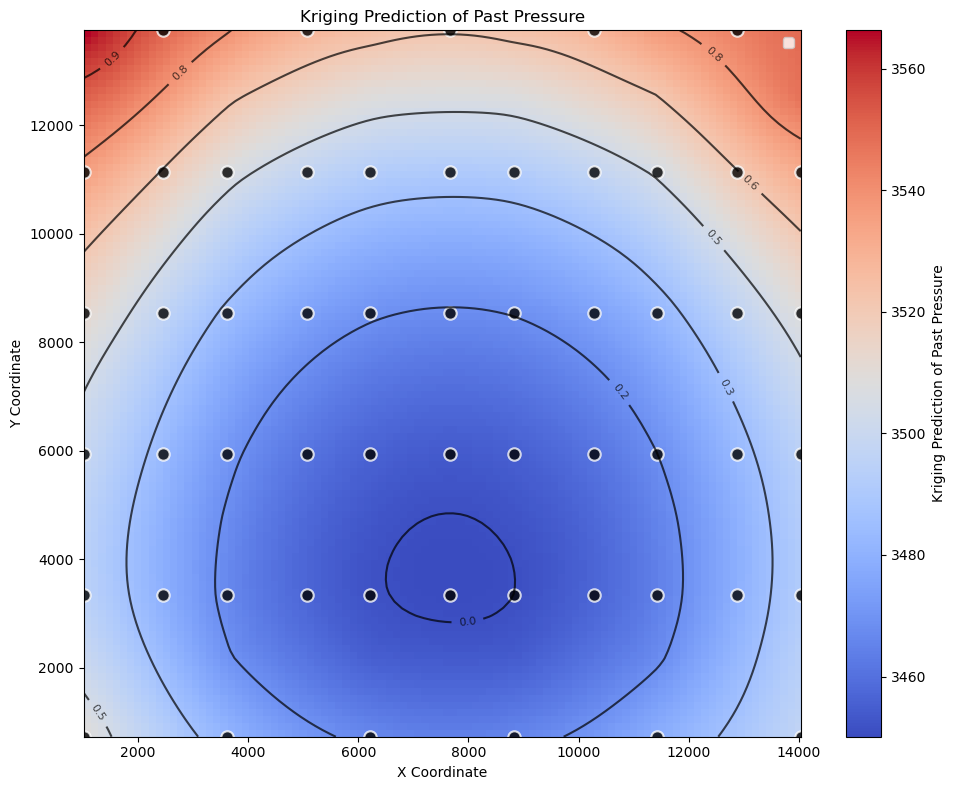

In [175]:
# Kriging plot for past pressure
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'past_pressure', 
                    'Kriging Prediction of Past Pressure',
                    cmap='coolwarm', add_contours=True, contour_col='total_depth_md')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_18032\2314285338.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


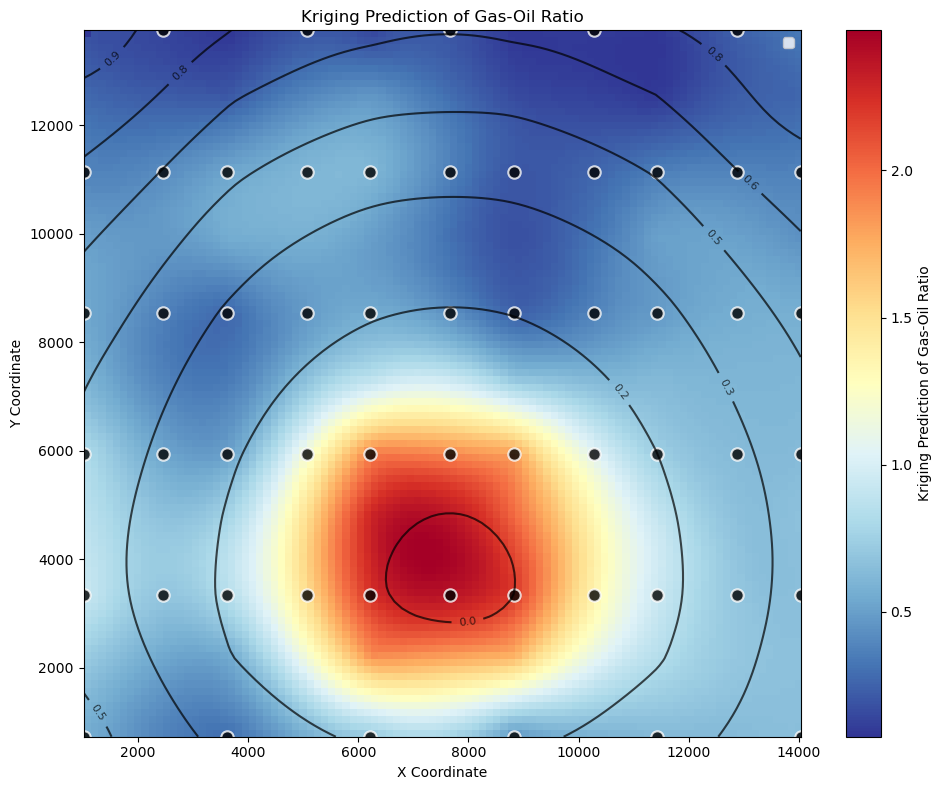

In [176]:
# Classify wells by fluid dominance using GOR
df_scaled['GOR'] = df_scaled['gas_prod_mmcf'] / (df_scaled['oil_prod_mstb'] + 0.001)
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'GOR', 
                    'Kriging Prediction of Gas-Oil Ratio',
                    cmap='RdYlBu_r', add_contours=True, contour_col='total_depth_md')
plt.show()

In [177]:
# Features for facies prediction
feature_cols = ['bh_x', 'bh_y', 'total_depth_md', 'porosity', 'perm_hm', 'past_pressure']

X = df_scaled[feature_cols].copy()
y = df_scaled['facies'].copy()

# Handle any missing values
X = X.fillna(X.median())

# Split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)

rf_classifier.fit(X_train, y_train)

# Evaluate
train_score = rf_classifier.score(X_train, y_train)
test_score = rf_classifier.score(X_test, y_test)
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)

print(f"Training Accuracy: {train_score:.3f}")
print(f"Test Accuracy: {test_score:.3f}")
print(f"Cross-validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")


Training Accuracy: 1.000
Test Accuracy: 1.000
Cross-validation Accuracy: 0.855 (+/- 0.123)


In [178]:
# Check for common samples in train/test
common_indices = set(X_train.index).intersection(set(X_test.index))
print("Common samples in train/test:", common_indices)

Common samples in train/test: set()


In [179]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance for Facies Prediction:")
print(feature_importance)


Feature Importance for Facies Prediction:
          feature  importance
3        porosity    0.404179
4         perm_hm    0.248877
5   past_pressure    0.124186
2  total_depth_md    0.118549
0            bh_x    0.066057
1            bh_y    0.038152


In [180]:
# Create dense grid over field
x_min, x_max = df['bh_x'].min(), df['bh_x'].max()
y_min, y_max = df['bh_y'].min(), df['bh_y'].max()

grid_x = np.linspace(x_min, x_max, 100)
grid_y = np.linspace(y_min, y_max, 100)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# Interpolate other features to grid using kriging
def krige_to_grid(df, feature, grid_x, grid_y):
    x = df['bh_x'].values
    y = df['bh_y'].values
    z = df_scaled[feature].values
    
    mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
    x, y, z = x[mask], y[mask], z[mask]
    
    OK = OrdinaryKriging(x, y, z, variogram_model='spherical',
                         verbose=False, enable_plotting=False)
    z_pred, _ = OK.execute('grid', grid_x, grid_y)
    return z_pred

In [181]:
# Krige all features
grid_depth = krige_to_grid(df_scaled, 'total_depth_md', grid_x, grid_y)
grid_porosity = krige_to_grid(df_scaled, 'porosity', grid_x, grid_y)
grid_perm = krige_to_grid(df_scaled, 'perm_hm', grid_x, grid_y)
grid_pressure = krige_to_grid(df_scaled, 'past_pressure', grid_x, grid_y)

In [182]:
# Prepare grid features for prediction
grid_features = np.column_stack([
    grid_xx.ravel(),
    grid_yy.ravel(),
    grid_depth.ravel(),
    grid_porosity.ravel(),
    grid_perm.ravel(),
    grid_pressure.ravel()
])

# Predict facies class
facies_pred = rf_classifier.predict(grid_features)
facies_pred_grid = facies_pred.reshape(grid_xx.shape)

# Predict probabilities for each facies
facies_proba = rf_classifier.predict_proba(grid_features)

c:\Users\shake\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\shake\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


C:\Users\shake\AppData\Local\Temp\ipykernel_18032\2314285338.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


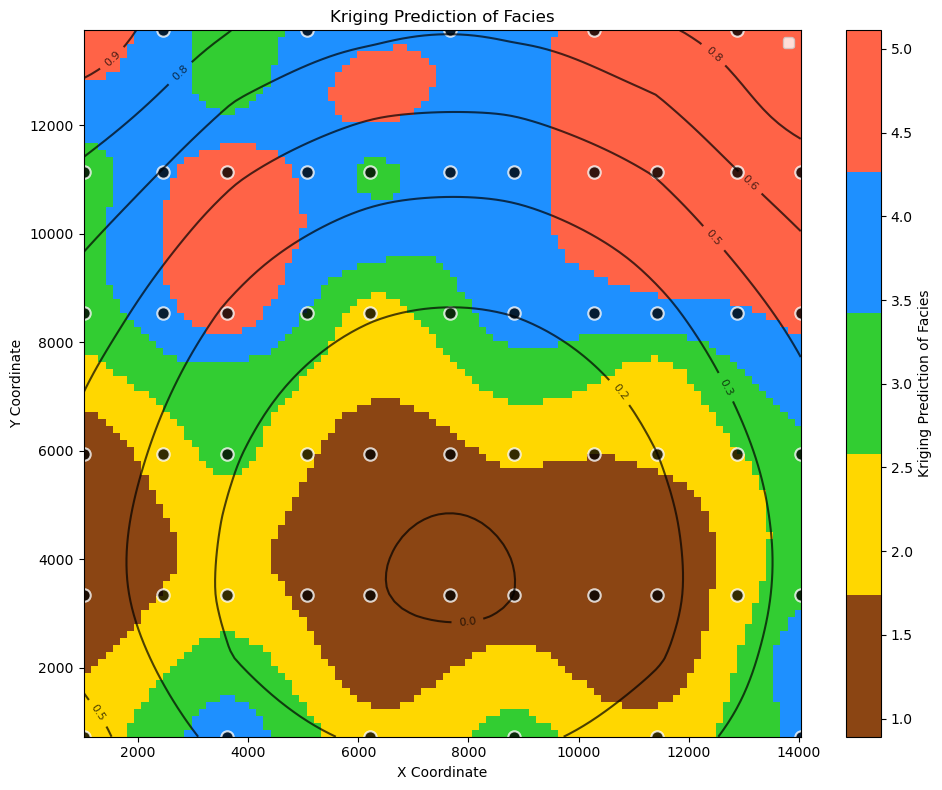

In [183]:
# Create custom colormap for facies
facies_colors = ['#8B4513', '#FFD700', '#32CD32', '#1E90FF', '#FF6347']
facies_cmap = ListedColormap(facies_colors[:len(np.unique(y))])

create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'facies', 
                    'Kriging Prediction of Facies',
                    cmap=facies_cmap, add_contours=True, contour_col='total_depth_md')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_18032\2314285338.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


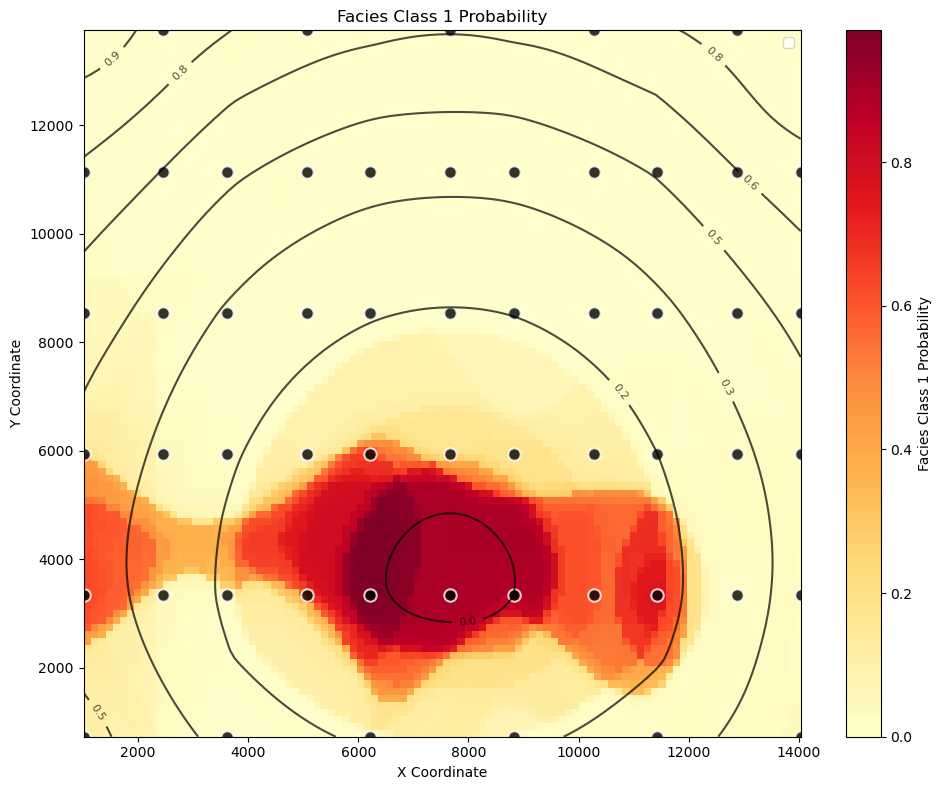

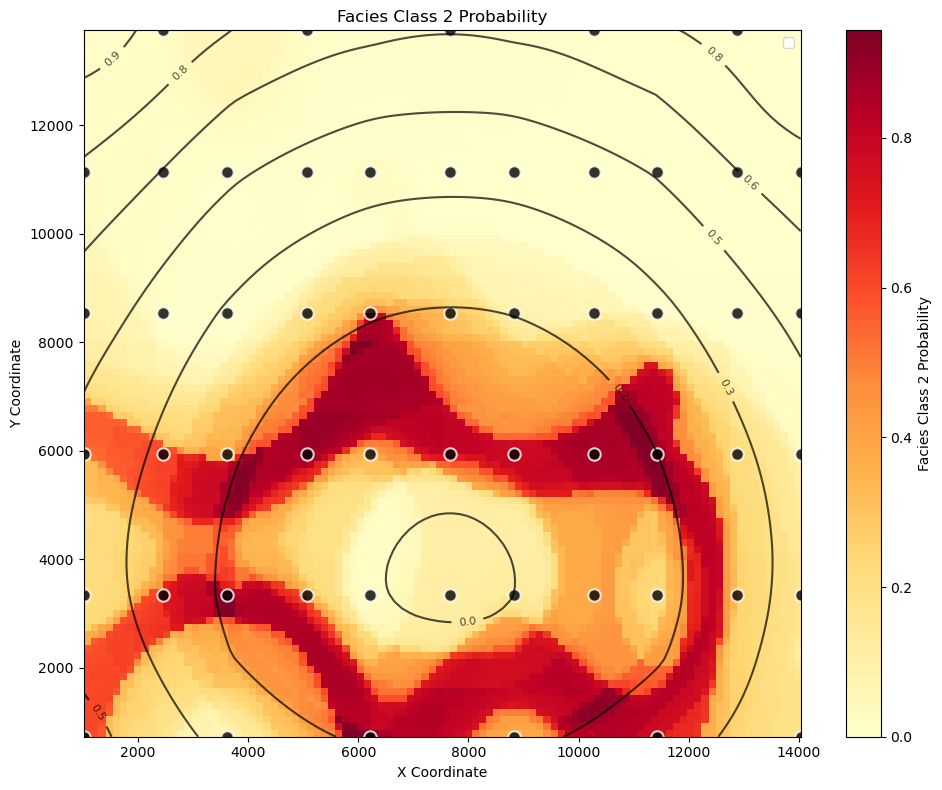

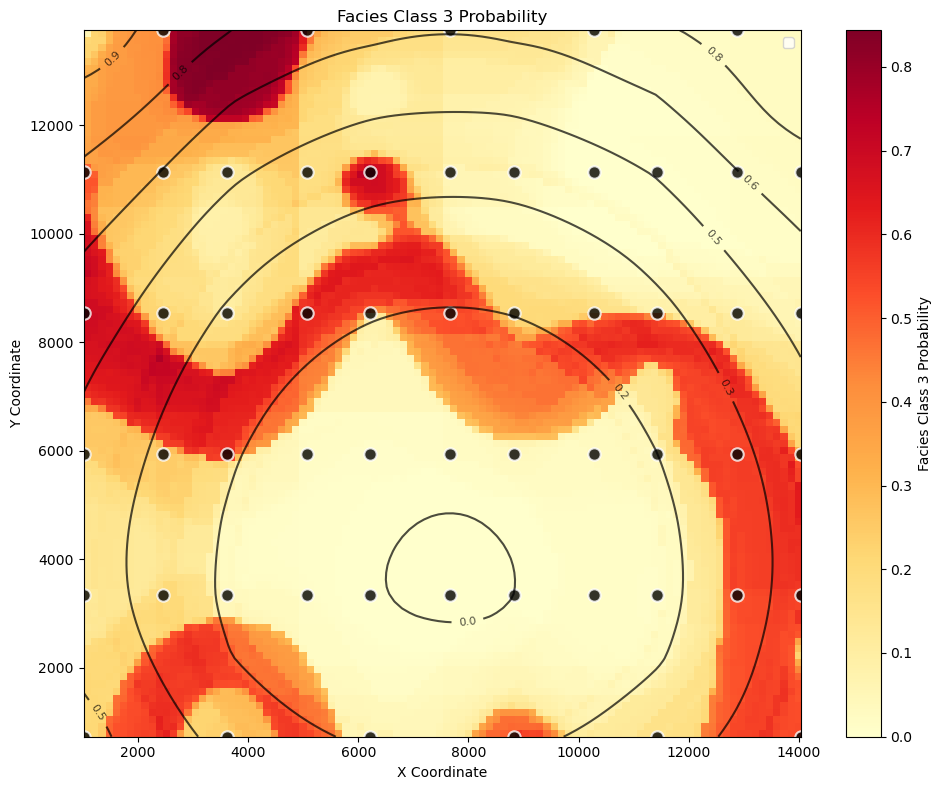

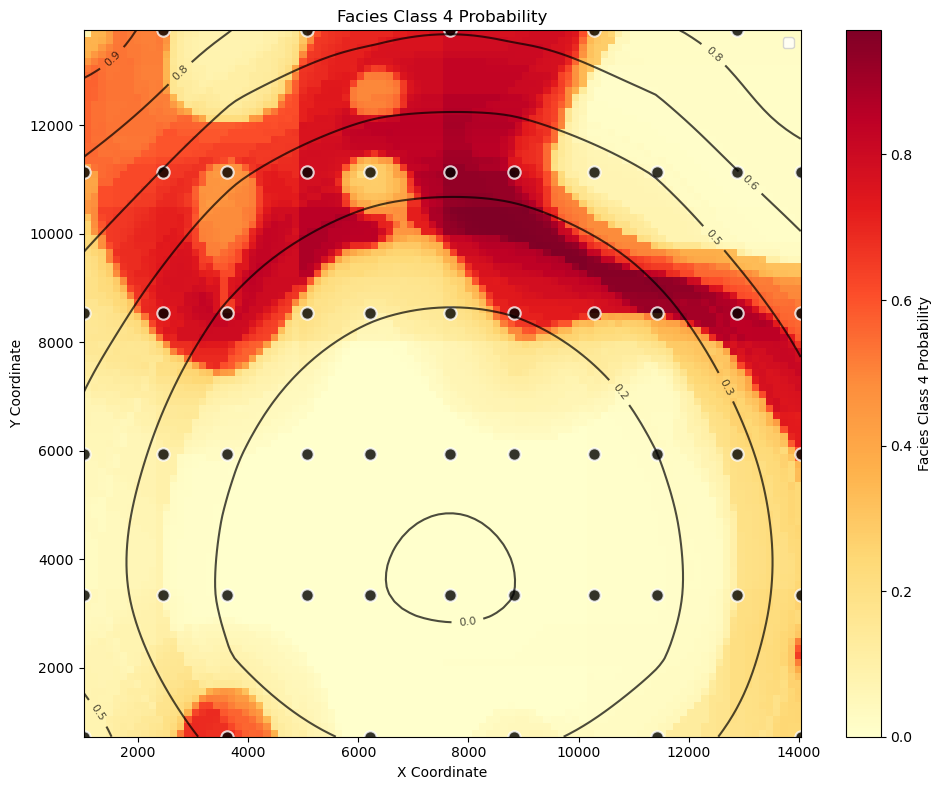

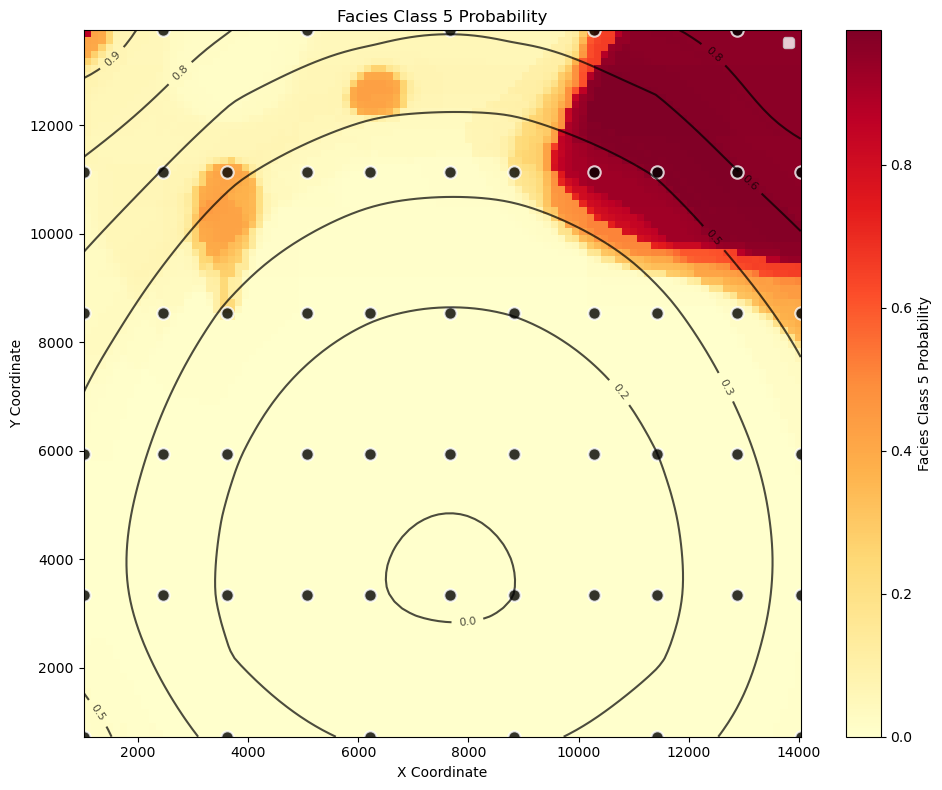

In [184]:
for idx, facies_class in enumerate(rf_classifier.classes_):
    facies_prob = facies_proba[:, idx].reshape(grid_xx.shape)
    
    fig = create_kriging_plot(df_scaled, 'bh_x', 'bh_y',
                              title=f'Facies Class {facies_class} Probability',
                              cmap='YlOrRd',
                              z_grid=facies_prob,
                              grid_x=grid_x, grid_y=grid_y,
                              add_contours=True, contour_col='total_depth_md')
    plt.show()

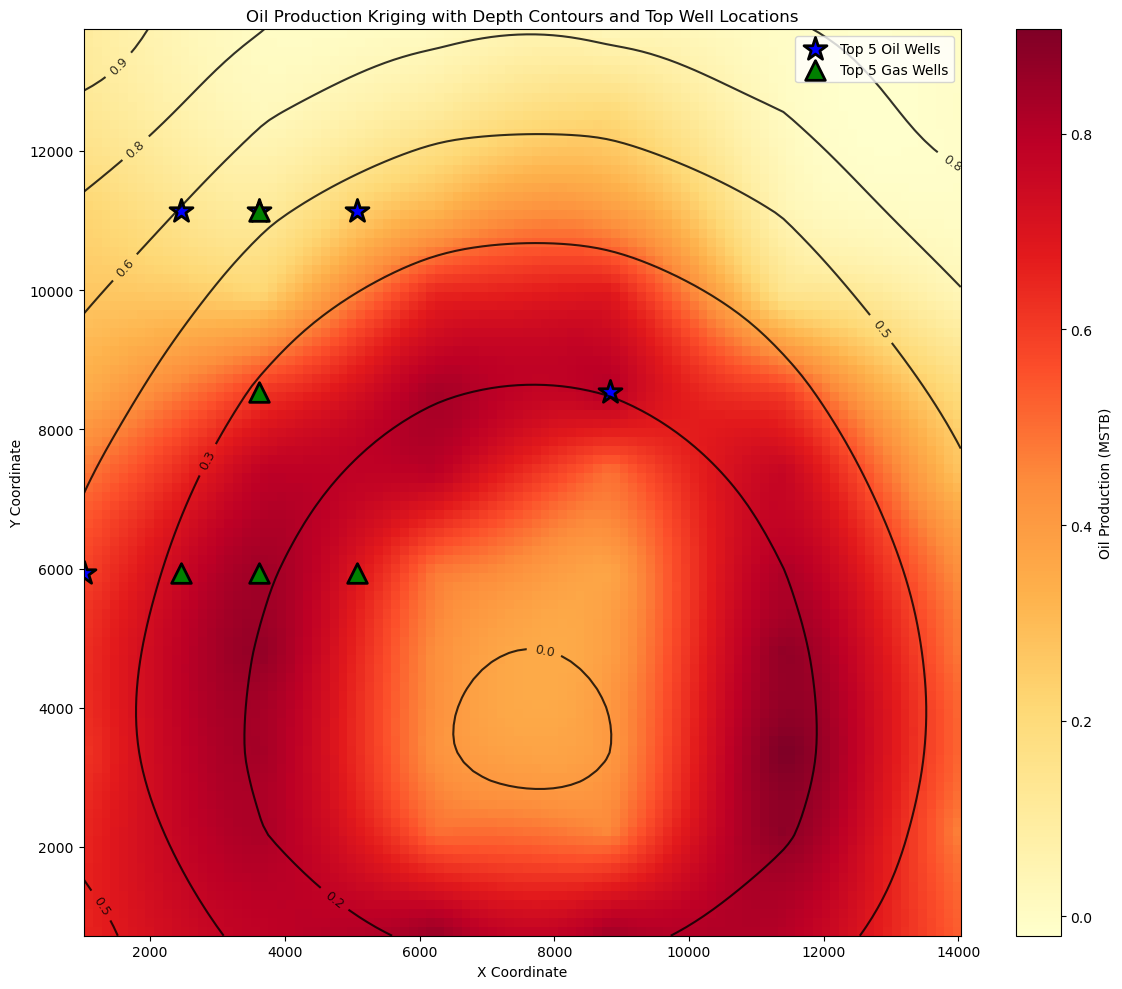

In [185]:
# Identify top wells
top_oil = df_scaled.nlargest(5, 'oil_prod_mstb')
top_gas = df_scaled.nlargest(5, 'gas_prod_mmcf')

# Create composite kriging plot with top wells marked
x = df['bh_x'].values
y = df['bh_y'].values
z = df_scaled['oil_prod_mstb'].values

mask = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
x, y, z = x[mask], y[mask], z[mask]

grid_x = np.linspace(x.min(), x.max(), 100)
grid_y = np.linspace(y.min(), y.max(), 100)

OK = OrdinaryKriging(x, y, z, variogram_model='spherical',
                     verbose=False, enable_plotting=False)
z_pred, ss = OK.execute('grid', grid_x, grid_y)

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(z_pred.T, extent=[x.min(), x.max(), y.min(), y.max()],
               origin='lower', cmap='YlOrRd', aspect='auto')
plt.colorbar(im, ax=ax, label='Oil Production (MSTB)')

# Add depth contours
depth = df_scaled['total_depth_md'].values
x_all = df['bh_x'].values
y_all = df['bh_y'].values

mask_depth = ~(np.isnan(x_all) | np.isnan(y_all) | np.isnan(depth))
x_depth, y_depth, z_depth = x_all[mask_depth], y_all[mask_depth], depth[mask_depth]

OK_depth = OrdinaryKriging(x_depth, y_depth, z_depth, variogram_model='spherical',
                           verbose=False, enable_plotting=False)
depth_pred, _ = OK_depth.execute('grid', grid_x, grid_y)

contours = ax.contour(grid_x, grid_y, depth_pred.T, 
                      colors='black', linewidths=1.5, levels=8, alpha=0.8)
ax.clabel(contours, inline=True, fontsize=9, fmt='%0.1f')

# Overlay top wells
ax.scatter(top_oil['bh_x'], top_oil['bh_y'], c='blue', s=300, 
           marker='*', edgecolor='black', linewidth=2, label='Top 5 Oil Wells')
ax.scatter(top_gas['bh_x'], top_gas['bh_y'], c='green', s=200, 
           marker='^', edgecolor='black', linewidth=2, label='Top 5 Gas Wells')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Oil Production Kriging with Depth Contours and Top Well Locations')
ax.legend()
plt.tight_layout()
plt.show()


In [186]:
# Compute average production by facies
facies_production = df_scaled.groupby('facies').agg({
    'oil_prod_mstb': ['mean', 'median', 'std'],
    'gas_prod_mmcf': ['mean', 'median', 'std']
}).round(3)

print("Production Statistics by Facies:")
print(facies_production)

Production Statistics by Facies:
       oil_prod_mstb               gas_prod_mmcf              
                mean median    std          mean median    std
facies                                                        
1              0.576  0.413  0.261         0.816  0.860  0.142
2              0.756  0.869  0.243         0.591  0.593  0.109
3              0.469  0.347  0.352         0.188  0.170  0.130
4              0.470  0.400  0.330         0.139  0.130  0.118
5              0.096  0.008  0.192         0.025  0.006  0.033


In [187]:
# Create facies quality score based on historical production
facies_quality = df_scaled.groupby('facies').agg({
    'oil_prod_mstb': 'mean',
    'gas_prod_mmcf': 'mean',
    'porosity': 'mean',
    'perm_hm': 'mean'
})
# Normalize facies scores
facies_quality['quality_score'] = (
    (facies_quality['oil_prod_mstb'] / facies_quality['oil_prod_mstb'].max()) * 0.35 +
    (facies_quality['gas_prod_mmcf'] / facies_quality['gas_prod_mmcf'].max()) * 0.35 +
    (facies_quality['porosity'] / facies_quality['porosity'].max()) * 0.15 +
    (facies_quality['perm_hm'] / facies_quality['perm_hm'].max()) * 0.15
)

print("\nFacies Quality Scores:")
print(facies_quality['quality_score'].sort_values(ascending=False))


Facies Quality Scores:
facies
1    0.916848
2    0.843851
3    0.460190
4    0.378507
5    0.079254
Name: quality_score, dtype: float64


In [202]:
# Map facies quality back to dataframe
df_scaled['facies_quality'] = df_scaled['facies'].map(facies_quality['quality_score'])

In [203]:
# Train Random Forest Classifier for facies prediction
feature_cols = ['bh_x', 'bh_y', 'total_depth_md', 'porosity', 'perm_hm', 'past_pressure']
X_facies = df_scaled[feature_cols].fillna(df_scaled[feature_cols].median())
y_facies = df_scaled['facies']

rf_facies = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'
)

rf_facies.fit(X_facies, y_facies)
print(f"\nFacies Classifier Training Accuracy: {rf_facies.score(X_facies, y_facies):.3f}")


Facies Classifier Training Accuracy: 1.000


In [204]:
# Define composite production target
df_scaled['target_production'] = df_scaled['oil_prod_mstb'] + (df_scaled['gas_prod_mmcf'])

# Features including facies information
production_features = ['bh_x', 'bh_y', 'total_depth_md', 'porosity', 
                       'perm_hm', 'past_pressure', 'facies_quality']

X_prod = df_scaled[production_features].fillna(df_scaled[production_features].median())
y_prod = df_scaled['target_production']

In [205]:
# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_prod, y_prod)

# Cross-validation
cv_scores = cross_val_score(xgb_model, X_prod, y_prod, cv=5, scoring='r2')
print(f"\nProduction Model CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")


Production Model CV R²: 0.781 (+/- 0.146)


In [206]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': production_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance for Production:")
print(feature_importance)


Feature Importance for Production:
          feature  importance
5   past_pressure    0.291365
6  facies_quality    0.192785
2  total_depth_md    0.182337
3        porosity    0.124553
0            bh_x    0.120184
4         perm_hm    0.080456
1            bh_y    0.008320


In [207]:
# Create spatial grid
x_min, x_max = df['bh_x'].min(), df['bh_x'].max()
y_min, y_max = df['bh_y'].min(), df['bh_y'].max()

grid_x = np.linspace(x_min, x_max, 150)
grid_y = np.linspace(y_min, y_max, 150)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

print("\nKriging features to grid...")
grid_depth = krige_to_grid(df, 'total_depth_md', grid_x, grid_y)
grid_porosity = krige_to_grid(df, 'porosity', grid_x, grid_y)
grid_perm = krige_to_grid(df, 'perm_hm', grid_x, grid_y)
grid_pressure = krige_to_grid(df, 'past_pressure', grid_x, grid_y)


Kriging features to grid...


In [208]:
# Predict facies on grid
grid_features_facies = np.column_stack([
    grid_xx.ravel(),
    grid_yy.ravel(),
    grid_depth.ravel(),
    grid_porosity.ravel(),
    grid_perm.ravel(),
    grid_pressure.ravel()
])

predicted_facies = rf_facies.predict(grid_features_facies)
predicted_facies_grid = predicted_facies.reshape(grid_xx.shape)

c:\Users\shake\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [209]:
# Map facies to quality scores
facies_quality_grid = np.vectorize(facies_quality['quality_score'].to_dict().get)(predicted_facies_grid)

In [210]:
# Predict production on grid using facies quality
grid_features_production = np.column_stack([
    grid_xx.ravel(),
    grid_yy.ravel(),
    grid_depth.ravel(),
    grid_porosity.ravel(),
    grid_perm.ravel(),
    grid_pressure.ravel(),
    facies_quality_grid.ravel()
])

predicted_production = xgb_model.predict(grid_features_production)
predicted_production_grid = predicted_production.reshape(grid_xx.shape)

In [211]:
# Normalize to sweet spot score (0-1)
sweet_spot_score = (predicted_production_grid - predicted_production_grid.min()) / \
                   (predicted_production_grid.max() - predicted_production_grid.min())

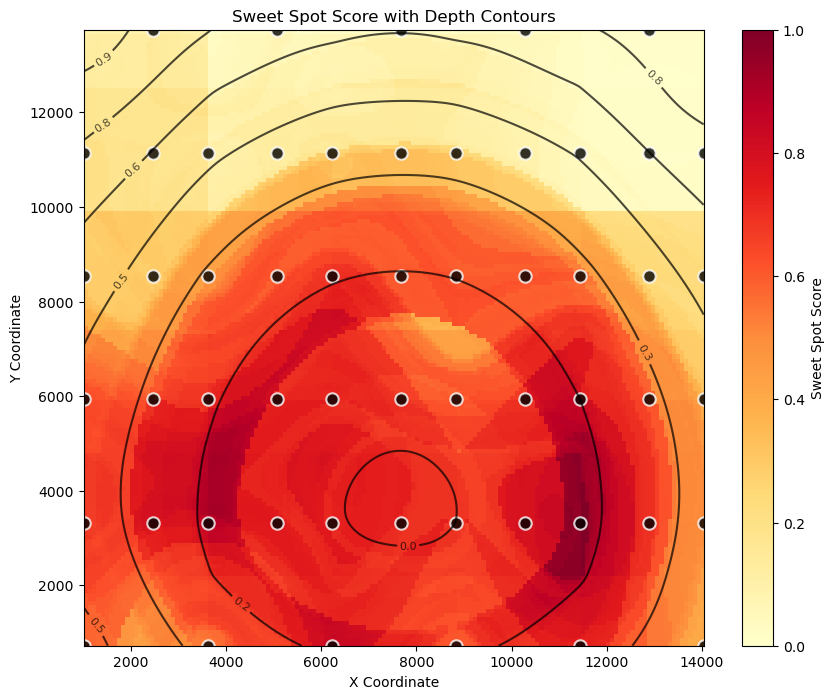

In [212]:
# Plot sweet spot score with depth contours
fig, ax = plt.subplots(figsize=(10, 8))

img = ax.imshow(sweet_spot_score.T, extent=[x_min, x_max, y_min, y_max],
                origin='lower', cmap='YlOrRd', aspect='auto')

contours = ax.contour(grid_x, grid_y, grid_depth.T, colors='black', linewidths=1.5, levels=8, alpha=0.7)
ax.clabel(contours, inline=True, fontsize=8, fmt='%0.1f')
#Overlay actual well locations colored by facies (using ORIGINAL df for coordinates)
ax.scatter(df_scaled['bh_x'], df_scaled['bh_y'], c='black', s=80, edgecolor='white', linewidth=1.5, alpha=0.8)
ax.set_title('Sweet Spot Score with Depth Contours')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

plt.colorbar(img, ax=ax, label='Sweet Spot Score')
plt.show()

C:\Users\shake\AppData\Local\Temp\ipykernel_18032\2314285338.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


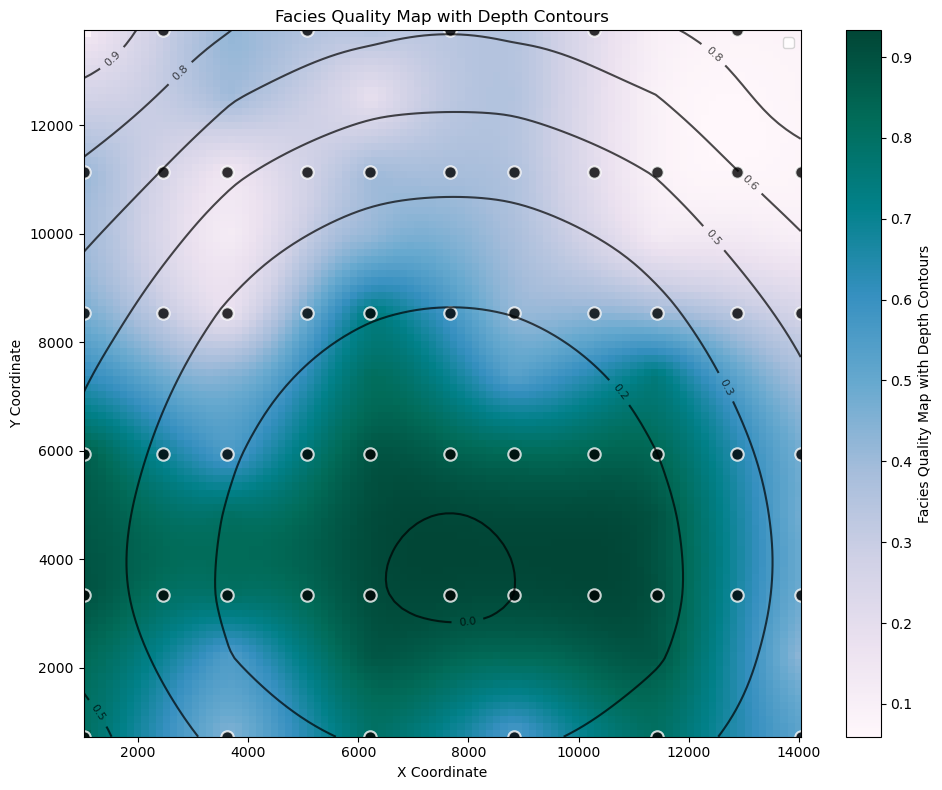

In [215]:
# Plot facies quality map with contours
create_kriging_plot(df_scaled, 'bh_x', 'bh_y', 'facies_quality',
                    'Facies Quality Map with Depth Contours',
                    cmap='PuBuGn', add_contours=True, contour_col='total_depth_md')
plt.show()

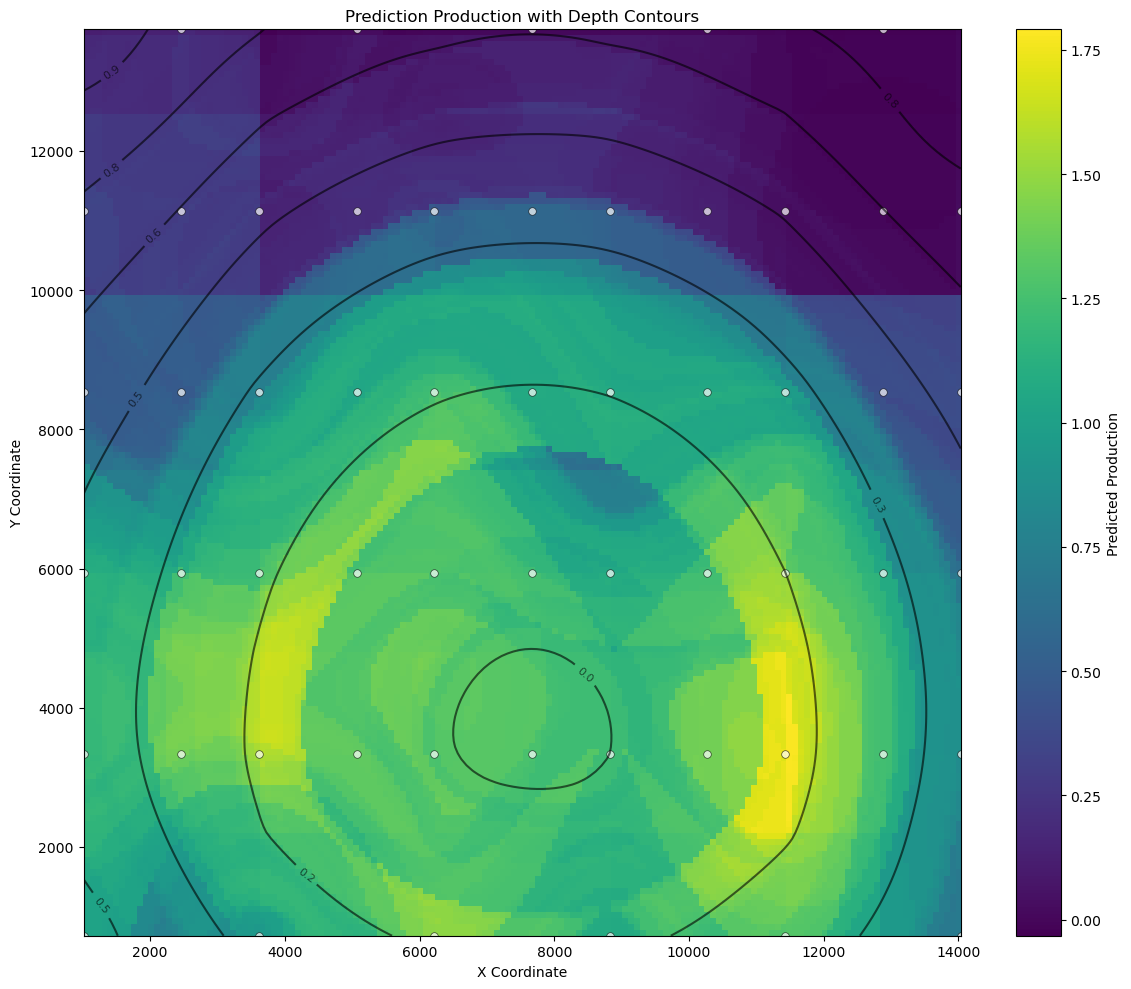

In [200]:
# Plot predicted production with depth contours
fig, ax = plt.subplots(figsize=(12, 10))

img = ax.imshow(predicted_production_grid.T, extent=[x_min, x_max, y_min, y_max],
                origin='lower', cmap='viridis', aspect='auto')
contours = ax.contour(grid_x, grid_y, grid_depth.T, 
                      colors='black', linewidths=1.5, levels=8, alpha=0.6)
ax.clabel(contours, inline=True, fontsize=8, fmt='%0.1f')
plt.colorbar(img, ax=ax, label='Predicted Production')

ax.scatter(df_scaled['bh_x'], df_scaled['bh_y'], c='white', s=30, 
           edgecolor='black', linewidth=0.5, alpha=0.7)
ax.set_title('Prediction Production with Depth Contours')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

plt.tight_layout()
plt.show()

In [201]:
# Find top sweet spot locations on grid
top_n = 10
flat_scores = sweet_spot_score.ravel()
top_indices = np.argsort(flat_scores)[-top_n:][::-1]

top_sweet_spots = pd.DataFrame({
    'bh_x': grid_xx.ravel()[top_indices],
    'bh_y': grid_yy.ravel()[top_indices],
    'sweet_spot_score': flat_scores[top_indices],
    'predicted_production': predicted_production.ravel()[top_indices],
    'predicted_facies': predicted_facies[top_indices],
    'depth': grid_depth.ravel()[top_indices],
    'porosity': grid_porosity.ravel()[top_indices],
    'permeability': grid_perm.ravel()[top_indices]
})

print("Top 10 Sweet Spot Locations for New Drilling")
print(top_sweet_spots.to_string(index=False))

Top 10 Sweet Spot Locations for New Drilling
       bh_x         bh_y  sweet_spot_score  predicted_production  predicted_facies    depth  porosity  permeability
4246.411342 11211.785705          1.000000              1.791022                 1 0.119412  0.957151      0.805177
4421.200604 11211.785705          1.000000              1.791022                 1 0.120740  0.953547      0.795970
4159.016711 11211.785705          1.000000              1.791022                 1 0.118856  0.959259      0.810332
4333.805973 11211.785705          1.000000              1.791022                 1 0.120041  0.955250      0.800386
4071.622081 11211.785705          0.997755              1.786930                 1 0.118374  0.961581      0.815781
3722.043557 11211.785705          0.995788              1.783342                 1 0.117298  0.972776      0.839621
3896.832819 11211.785705          0.995788              1.783342                 1 0.117644  0.966871      0.827465
3984.227450 11211.785705   